# Model `BinaryMFPenalty`

In [8]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[I] m            : 300
[I] n            : 500
[I] k            : 5
[I] overlap      : 4
[I] seed         : 1000
[I] noise        : 2
[I] seed         : 2000
[I] Using RandomState.


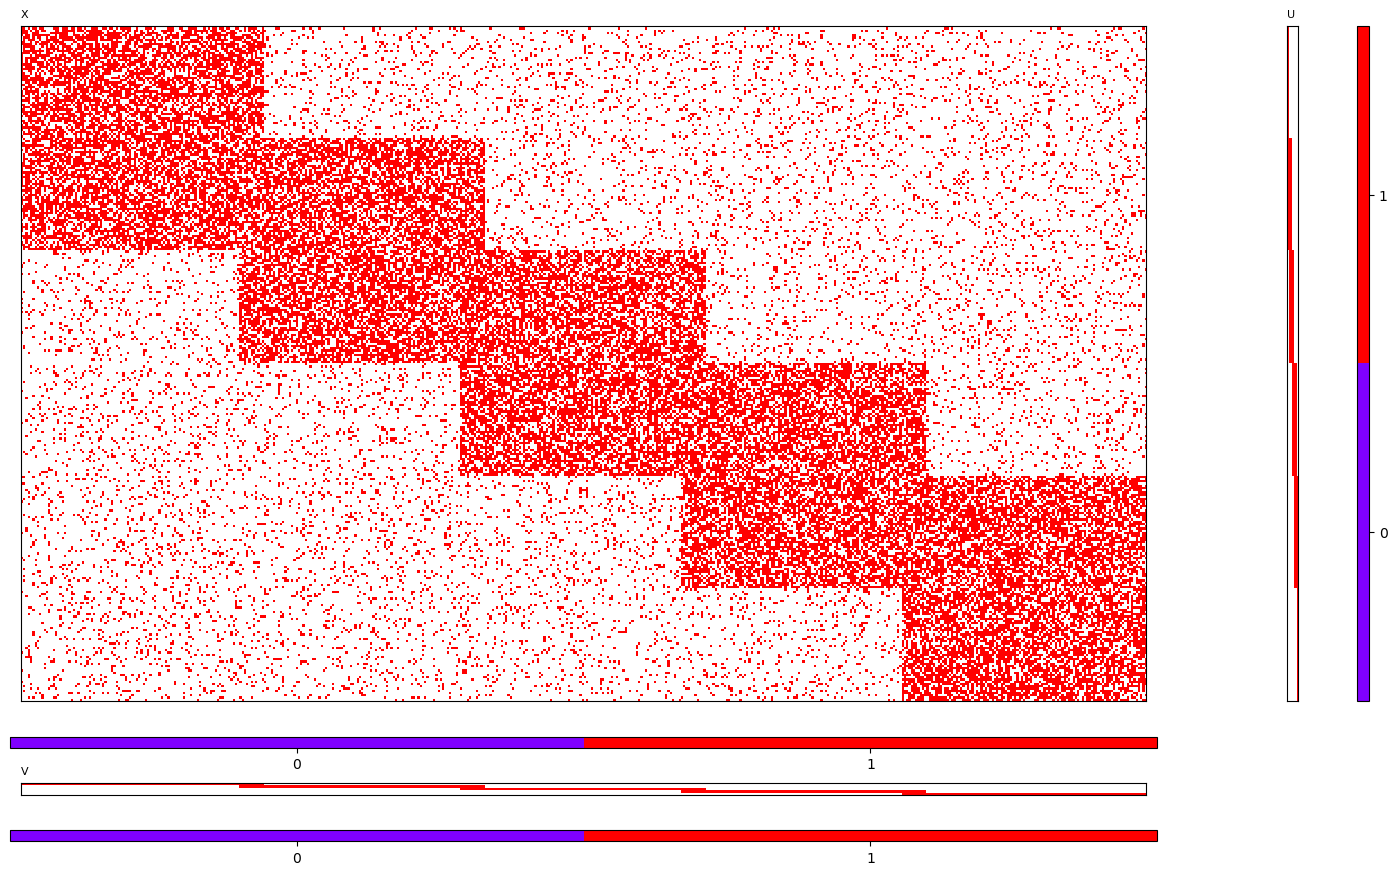

<Figure size 640x480 with 0 Axes>

In [9]:
from generators import BlockDiagonalMatrixGenerator

data = BlockDiagonalMatrixGenerator(m=300, n=500, k=5, overlap=[0.5, 0.1, 0.5, 0.1])
data.generate(seed=1000)

data.add_noise(noise=[0.4, 0.1], seed=2000)
data.show_matrix()

In [10]:
# from datasets import MovieLensData

# data = MovieLensData(size="100k")
# data.load()

# idx = data.sample(factor_id=0, n_samples=300, seed=1000)
# idx = data.sample(factor_id=1, n_samples=500, seed=1000)

In [11]:
from datasets import RatioSplit, NoSplit

# split = RatioSplit(X=data.X, val_size=0.1, test_size=0.2, seed=1997)
# split.negative_sample(
#     train_size=split.pos_train_size, 
#     val_size=split.pos_val_size, 
#     test_size=split.pos_test_size, 
#     seed=2023, type='popularity')

split = NoSplit(X=data.X)

X_train, X_val, X_test = split.X_train, split.X_val, split.X_test

[I] NoSplit, sampling positives
[I] RatioSplit, sampling positives
[I]   seed         : 1718603567
[I]   train_size   : 43279
[I]   val_size     : 0
[I]   test_size    : 0
[I]   seed         : 1718603567


# 1.1 Init U, V with `NMFSklearn` / `WNMF`

Note that for multiplicative update, it's better to replace the zeros in init U, V with small values. 
Otherwise, these entries will not be updated.

[I] k            : 5
[I] U            : None
[I] V            : None
[I] beta_loss    : frobenius
[I] init_method  : nndsvd
[I] solver       : cd
[I] tol          : 0.0001
[I] max_iter     : 1000
[I] seed         : 2024
[I] verbose      : False
[I] display      : False
[I] task         : reconstruction
[I] Missing validation data.
[W] Missing testing data.
[I] U, V existed. Skipping initialization.


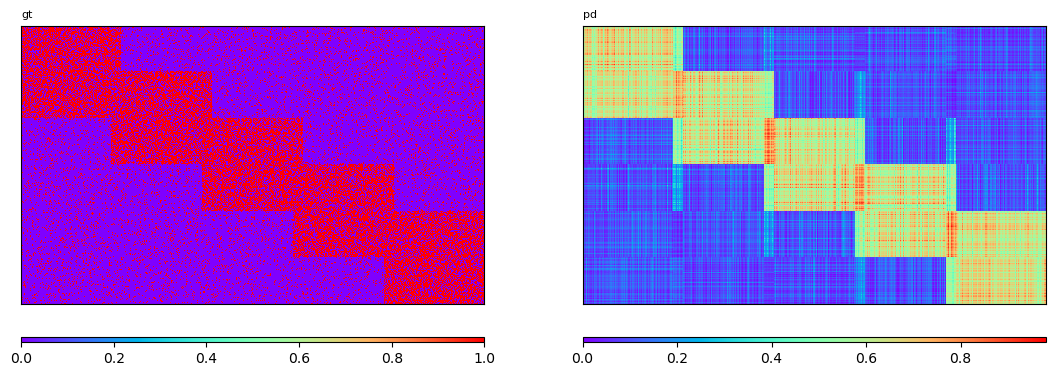

[I] model saved as: 24-06-17_13-52-48_NMFSklearn.pickle


<Figure size 640x480 with 0 Axes>

In [12]:
from models import NMFSklearn, WNMF

k = 5

model_nmf = NMFSklearn(k=k, init_method='nndsvd', max_iter=1000, seed=2024)
# model_nmf = WNMF(k=k, W='full', beta_loss='frobenius', init_method='normal', max_iter=1000, seed=2024)

model_nmf.fit(X_train=X_train, task='reconstruction', verbose=False, display=False)

In [13]:
# init U and V
U, V = model_nmf.U, model_nmf.V

# replace zeros
import numpy as np
U[U == 0] = np.finfo(float).eps
V[V == 0] = np.finfo(float).eps

# params for BinaryMFPenalty and BinaryMFPenaltyExSigmoid
k = 5
reg = 1
reg_growth = 2
W = 'full'
task = 'reconstruction'

# params for BinaryMFThresholdExSigmoid
u, v = 0.1, 0.1

c:\Users\nieht\miniconda3\envs\py39\lib\site-packages\IPython\core\interactiveshell.py:3550: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\nieht\miniconda3\envs\py39\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# 1.1 Load U, V from `NMFSklearn` / `WNMF`

Since the regularizer `reg` grows at a rate of `reg_growth`， the total `error` might be constantly increasing. The `reg_error` is decreasing and is considered the convergence indicator.

[I] k            : 5
[I] U            : (300, 5)
[I] V            : (500, 5)
[I] W            : full
[I] reg          : 1
[I] beta_loss    : frobenius
[I] solver       : mu
[I] reg_growth   : 2
[I] max_reg      : 10000000000.0
[I] tol          : 0.01
[I] min_diff     : 0.0
[I] max_iter     : 100
[I] init_method  : custom
[I] seed         : 2024
[I] verbose      : False
[I] display      : False
[I] task         : reconstruction
[I] verbose      : True
[I] display      : True
[I] Normalized U: [2.220446049250313e-16, 1.1180101669745808] -> [1.9860696394729632e-16, 1.0], V: [2.220446049250313e-16, 1.2039005684438508] -> [1.844376610038849e-16, 1.0]
(500, 5) 1.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 1, error: 1.06e+04, rec_error: 1.06e+04, reg: 1.00e+00, reg_error: 2.35e+01
(500, 5) 2.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 2, error: 1.03e+04, rec_error: 1.03e+04, reg: 2.00e+00, reg_error: 4.67e+01
(500

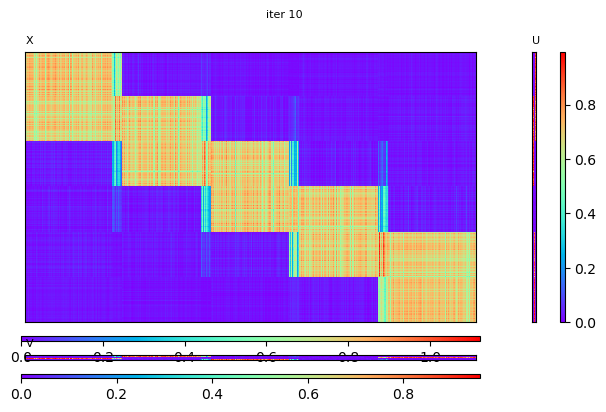

(500, 5) 1024.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 11, error: 1.76e+04, rec_error: 1.11e+04, reg: 1.02e+03, reg_error: 6.54e+03
(500, 5) 2048.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 12, error: 2.07e+04, rec_error: 1.16e+04, reg: 2.05e+03, reg_error: 9.09e+03
(500, 5) 4096.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 13, error: 2.44e+04, rec_error: 1.21e+04, reg: 4.10e+03, reg_error: 1.23e+04
(500, 5) 8192.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 14, error: 2.89e+04, rec_error: 1.26e+04, reg: 8.19e+03, reg_error: 1.64e+04
(500, 5) 16384.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 15, error: 3.46e+04, rec_error: 1.30e+04, reg: 1.64e+04, reg_error: 2.16e+04
(500, 5) 32768.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 16, error: 4.21e+04, rec_

<Figure size 640x480 with 0 Axes>

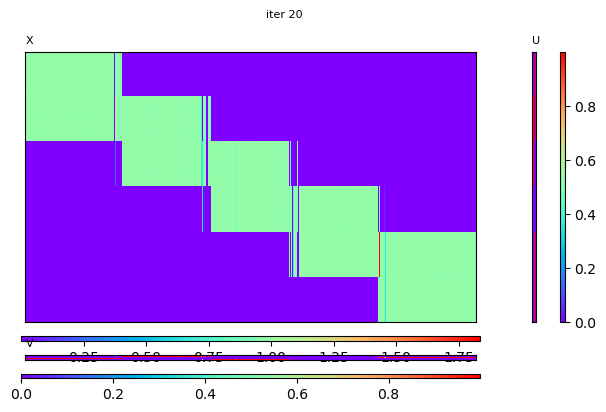

(500, 5) 1048576.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 21, error: 1.67e+05, rec_error: 1.45e+04, reg: 1.05e+06, reg_error: 1.53e+05
(500, 5) 2097152.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 22, error: 2.26e+05, rec_error: 1.46e+04, reg: 2.10e+06, reg_error: 2.11e+05
(500, 5) 4194304.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 23, error: 3.02e+05, rec_error: 1.46e+04, reg: 4.19e+06, reg_error: 2.87e+05
(500, 5) 8388608.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 24, error: 3.91e+05, rec_error: 1.46e+04, reg: 8.39e+06, reg_error: 3.77e+05
(500, 5) 16777216.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 25, error: 4.77e+05, rec_error: 1.47e+04, reg: 1.68e+07, reg_error: 4.63e+05
(500, 5) 33554432.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 26, err

<Figure size 640x480 with 0 Axes>

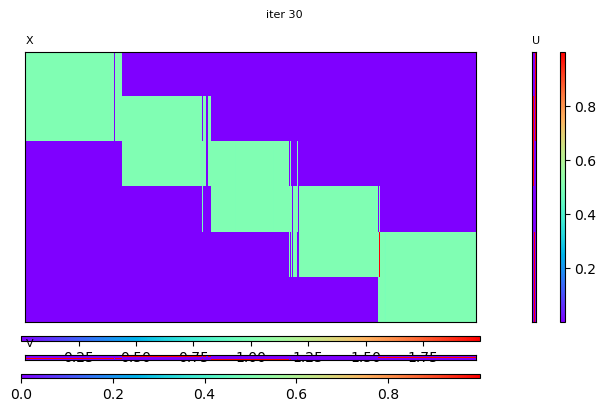

(500, 5) 1073741824.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 31, error: 5.35e+05, rec_error: 1.47e+04, reg: 1.07e+09, reg_error: 5.20e+05
(500, 5) 2147483648.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 32, error: 4.93e+05, rec_error: 1.47e+04, reg: 2.15e+09, reg_error: 4.79e+05
(500, 5) 4294967296.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 33, error: 4.50e+05, rec_error: 1.47e+04, reg: 4.29e+09, reg_error: 4.36e+05
(500, 5) 8589934592.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 34, error: 4.08e+05, rec_error: 1.47e+04, reg: 8.59e+09, reg_error: 3.93e+05
(500, 5) 10000000000.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 35, error: 2.20e+05, rec_error: 1.47e+04, reg: 1.00e+10, reg_error: 2.06e+05
(500, 5) 10000000000.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>

<Figure size 640x480 with 0 Axes>

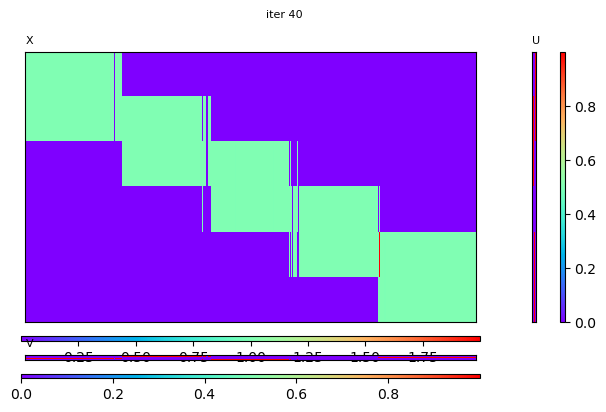

(500, 5) 10000000000.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 41, error: 1.64e+04, rec_error: 1.48e+04, reg: 1.00e+10, reg_error: 1.62e+03
(500, 5) 10000000000.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 42, error: 1.55e+04, rec_error: 1.48e+04, reg: 1.00e+10, reg_error: 7.19e+02
(500, 5) 10000000000.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 43, error: 1.51e+04, rec_error: 1.48e+04, reg: 1.00e+10, reg_error: 3.20e+02
(500, 5) 10000000000.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 44, error: 1.49e+04, rec_error: 1.48e+04, reg: 1.00e+10, reg_error: 1.42e+02
(500, 5) 10000000000.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 45, error: 1.48e+04, rec_error: 1.48e+04, reg: 1.00e+10, reg_error: 6.32e+01
(500, 5) 10000000000.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float

<Figure size 640x480 with 0 Axes>

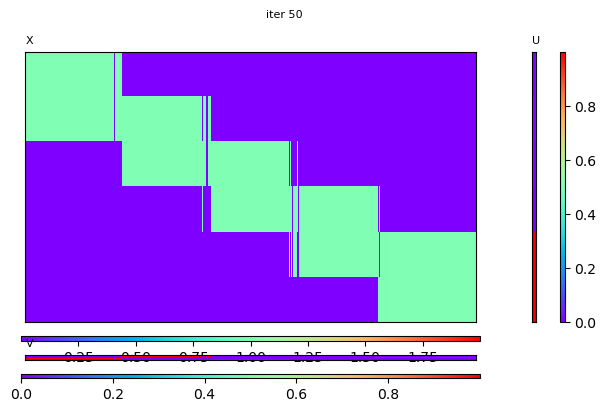

(500, 5) 10000000000.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 51, error: 1.48e+04, rec_error: 1.48e+04, reg: 1.00e+10, reg_error: 4.89e-01
(500, 5) 10000000000.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 52, error: 1.48e+04, rec_error: 1.48e+04, reg: 1.00e+10, reg_error: 2.18e-01
(500, 5) 10000000000.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 53, error: 1.48e+04, rec_error: 1.48e+04, reg: 1.00e+10, reg_error: 9.70e-02
(500, 5) 10000000000.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 54, error: 1.48e+04, rec_error: 1.48e+04, reg: 1.00e+10, reg_error: 4.33e-02
(500, 5) 10000000000.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
[I] iter: 55, error: 1.48e+04, rec_error: 1.48e+04, reg: 1.00e+10, reg_error: 1.94e-02
(500, 5) 10000000000.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float

\
                                                                        
                 time iter          error     rec_error           reg   
0   17/06/24 01:52:49    0   10590.355960  10569.940054  1.000000e+00   
1   17/06/24 01:52:50    1   10593.409595  10569.940054  1.000000e+00   
2   17/06/24 01:52:50    2   10327.913052  10281.209377  2.000000e+00   
3   17/06/24 01:52:50    3   10373.536835  10281.165143  4.000000e+00   
4   17/06/24 01:52:50    4   10462.460442  10281.664875  8.000000e+00   
5   17/06/24 01:52:50    5   10631.040532  10283.683255  1.600000e+01   
6   17/06/24 01:52:50    6   10937.868613  10290.636663  3.200000e+01   
7   17/06/24 01:52:50    7   11464.335407  10311.957173  6.400000e+01   
8   17/06/24 01:52:51    8   12303.662490  10368.770842  1.280000e+02   
9   17/06/24 01:52:51    9   13548.145393  10497.153142  2.560000e+02   
10  17/06/24 01:52:51   10   15296.076918  10737.708405  5.120000e+02   
11  17/06/24 01:52:52   11   17647.701092  11105.898231  1.024000e+03   
12  17/06/24 01:52:52   12   20666.503665  11571.849379  2.048000e+03   
13  17/06/24 01:52:52   13   24400.826324  12080.977066  4.096000e+03   
14  17/06/24 01:52:52   14   28947.518962  12583.392744  8.192000e+03   
15  17/06/24 01:52:53   15   34613.526702  13045.723640  1.638400e+04   
16  17/06/24 01:52:53   16   42143.141156  13448.615050  3.276800e+04   
17  17/06/24 01:52:53   17   52788.276165  13778.897054  6.553600e+04   
18  17/06/24 01:52:53   18   68616.670021  14035.658977  1.310720e+05   
19  17/06/24 01:52:53   19   91413.319539  14229.205274  2.621440e+05   
20  17/06/24 01:52:53   20  122962.631452  14371.818929  5.242880e+05   
21  17/06/24 01:52:54   21  167173.125782  14476.967644  1.048576e+06   
22  17/06/24 01:52:54   22  225827.176682  14553.828636  2.097152e+06   
23  17/06/24 01:52:55   23  302018.424139  14609.117379  4.194304e+06   
24  17/06/24 01:52:55   24  391217.817712  14649.155536  8.388608e+06   
25  17/06/24 01:52:55   25  477424.691881  14678.079404  1.677722e+07   
26  17/06/24 01:52:55   26  546662.531449  14699.149401  3.355443e+07   
27  17/06/24 01:52:55   27  590011.812717  14714.569172  6.710886e+07   
28  17/06/24 01:52:55   28  605584.127519  14725.746523  1.342177e+08   
29  17/06/24 01:52:55   29  597238.054285  14733.733732  2.684355e+08   
30  17/06/24 01:52:55   30  571541.526788  14739.355230  5.368709e+08   
31  17/06/24 01:52:57   31  535155.436424  14743.257554  1.073742e+09   
32  17/06/24 01:52:57   32  493472.429721  14745.936050  2.147484e+09   
33  17/06/24 01:52:57   33  450289.609129  14747.758706  4.294967e+09   
34  17/06/24 01:52:57   34  408012.344654  14748.991163  8.589935e+09   
35  17/06/24 01:52:57   35  220378.333879  14749.820804  1.000000e+10   
36  17/06/24 01:52:57   36  106787.943675  14750.377511  1.000000e+10   
37  17/06/24 01:52:57   37   55849.953564  14750.750285  1.000000e+10   
38  17/06/24 01:52:57   38   33075.099327  14750.999538  1.000000e+10   
39  17/06/24 01:52:58   39   22912.444852  14751.166036  1.000000e+10   
40  17/06/24 01:52:58   40   18383.660372  14751.277182  1.000000e+10   
41  17/06/24 01:52:59   41   16367.290431  14751.351345  1.000000e+10   
42  17/06/24 01:52:59   42   15470.067023  14751.400817  1.000000e+10   
43  17/06/24 01:52:59   43   15070.988883  14751.433811  1.000000e+10   
44  17/06/24 01:52:59   44   14893.529593  14751.455812  1.000000e+10   
45  17/06/24 01:52:59   45   14814.632655  14751.470483  1.000000e+10   
46  17/06/24 01:52:59   46   14779.560204  14751.480264  1.000000e+10   
47  17/06/24 01:53:00   47   14763.970733  14751.486786  1.000000e+10   
48  17/06/24 01:53:00   48   14757.041839  14751.491133  1.000000e+10   
49  17/06/24 01:53:00   49   14753.962438  14751.494032  1.000000e+10   
50  17/06/24 01:53:00   50   14752.593967  14751.495965  1.000000e+10   
51  17/06/24 01:53:01   51   14751.985882  14751.497253  1.000000e+10   
52  17/06/24 01:53:02   52   14751.715712  14751.498112 

<Figure size 640x480 with 0 Axes>

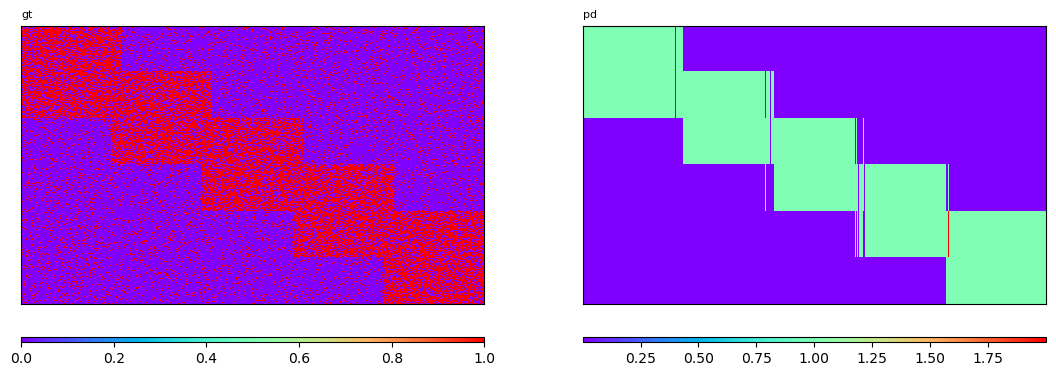

[I] model saved as: 24-06-17_13-53-03_BinaryMFPenalty.pickle


<Figure size 640x480 with 0 Axes>

In [14]:
from models import BinaryMFPenalty

X_train, X_val, X_test = split.X_train, split.X_val, split.X_test

model = BinaryMFPenalty(k=k, U=U, V=V, W=W, reg=reg, reg_growth=reg_growth, init_method='custom', max_iter=100, seed=2024)
model.fit(X_train=X_train, X_val=X_val, X_test=X_test, task=task, verbose=True, display=True)

# 1.2 Thresholding with `BinaryMFThresholdExSigmoid`

[I] k            : 5
[I] U            : (300, 5)
[I] V            : (500, 5)
[I] W            : full
[I] u            : 0.1
[I] v            : 0.1
[I] link_lamda   : 10
[I] lamda        : 20
[I] min_diff     : 0.001
[I] max_iter     : 30
[I] init_method  : custom
[I] seed         : 1718603583
[I] verbose      : False
[I] display      : False
[I] task         : reconstruction
[I] Normalized U: [9.999998494001971e-11, 0.999999997779853] -> [9.999998516203438e-11, 1.0], V: [1.5421402013123361e-31, 0.9999999969377357] -> [1.542140206925095e-31, 1.0]
[I] iter: 1, start: [0.100, 0.100], direction: [3602.685, 6363.804]
[I] iter: 2, start: [0.127, 0.149], direction: [-357.161, -388.185]
[I] iter: 3, start: [0.095, 0.113], direction: [1204.712, 1738.046]
[I] iter: 4, start: [0.701, 0.988], direction: [0.002, 0.476]
[W] Stopped in advance: Difference lower than threshold


train  \
                                                                    0   
                time iter         u         v             F    Recall   
0  17/06/24 01:53:04    0  0.100000  0.100000  14485.610123  0.732434   
1  17/06/24 01:53:04    1  0.127486  0.148552  14319.406653  0.732434   
2  17/06/24 01:53:05    2  0.094787  0.113013  14128.111954  0.732434   
3  17/06/24 01:53:06    3  0.701408  0.988189  11425.418759  0.732434   
4  17/06/24 01:53:06    4  0.701408  0.988189  11425.418757  0.732434   

                                      val                                \
                                        0                                 
  Precision  Accuracy        F1    Recall Precision  Accuracy        F1   
0  0.639738  0.803793  0.682955  0.732434  0.639738  0.803793  0.682955   
1  0.639738  0.803793  0.682955  0.732434  0.639738  0.803793  0.682955   
2  0.639738  0.803793  0.682955  0.732434  0.639738  0.803793  0.682955   
3  0.639738  0.803793  0.682955  0.732434  0.639738  0.803793  0.682955   
4  0.639738  0.803793  0.682955  0.732434  0.639738  0.803793  0.682955   

       test                                
          0                                
     Recall Precision  Accuracy        F1  
0  0.732434  0.639738  0.803793  0.682955  
1  0.732434  0.639738  0.803793  0.682955  
2  0.732434  0.639738  0.803793  0.682955  
3  0.732434  0.639738  0.803793  0.682955  
4  0.732434  0.639738  0.803793  0.682955

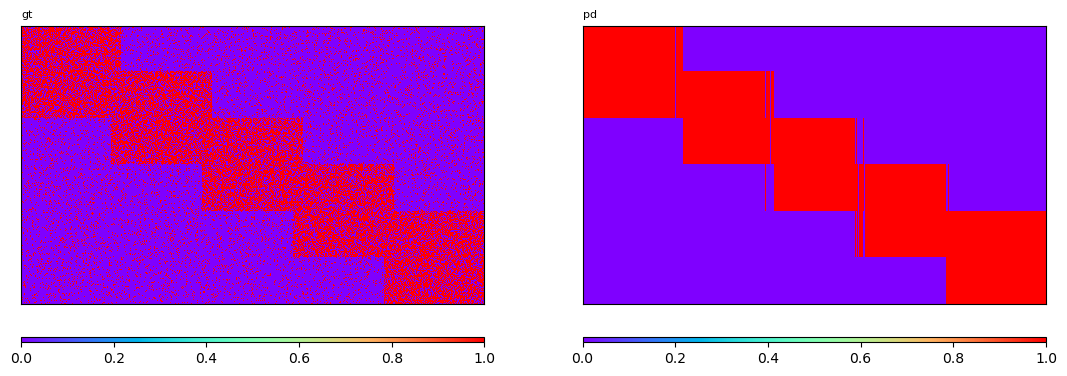

[I] model saved as: 24-06-17_13-53-07_BinaryMFThresholdExSigmoid.pickle


<Figure size 640x480 with 0 Axes>

In [15]:
from models import BinaryMFThresholdExSigmoid

model_bmfts_1 = BinaryMFThresholdExSigmoid(k=k, U=model.U, V=model.V, W=W, u=u, v=v, init_method='custom', lamda=20)
model_bmfts_1.fit(X_train=X_train, X_val=X_val, X_test=X_test, task=task, verbose=False, display=False)

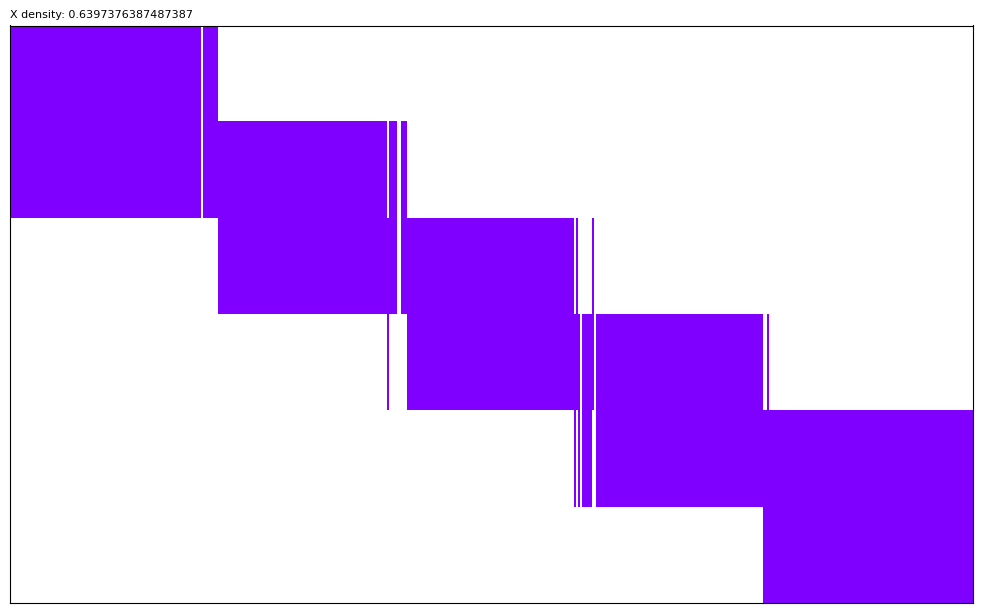

<Figure size 640x480 with 0 Axes>

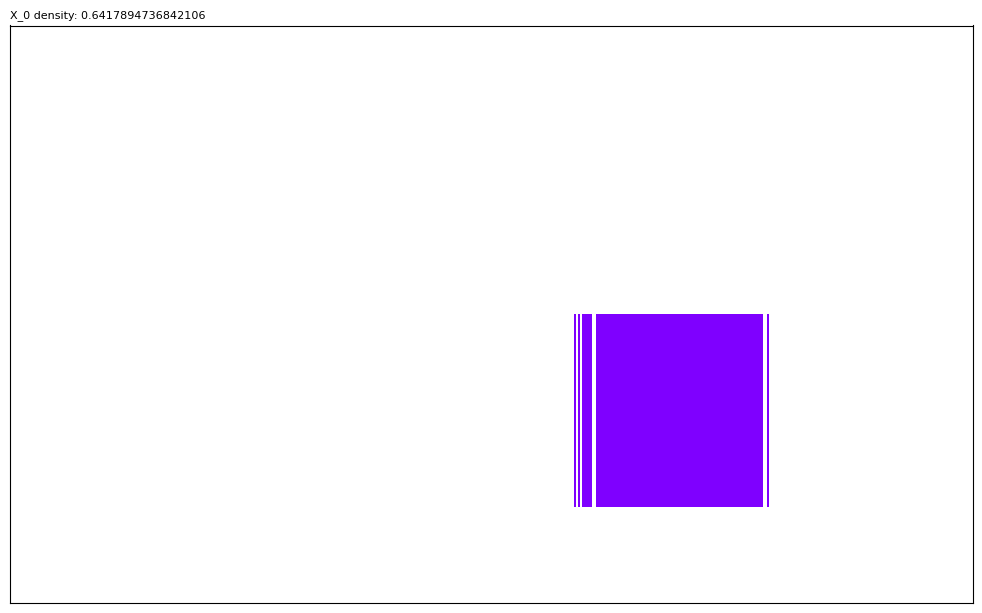

<Figure size 640x480 with 0 Axes>

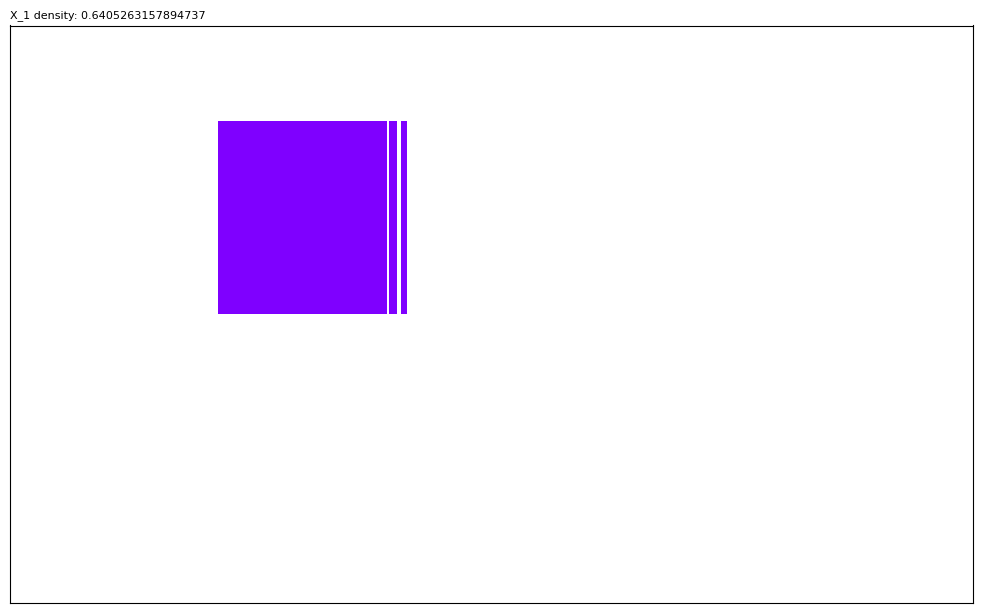

<Figure size 640x480 with 0 Axes>

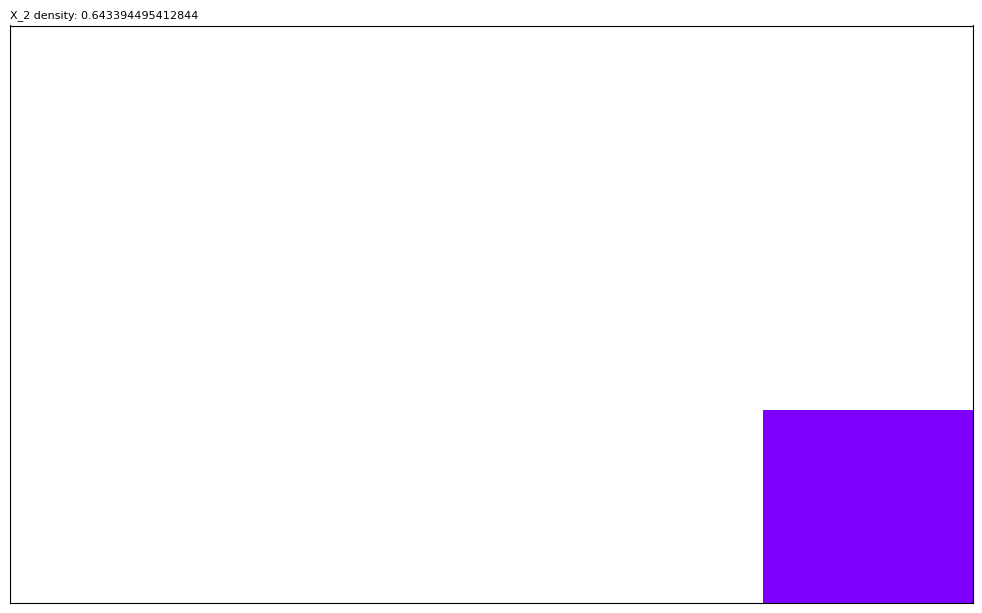

<Figure size 640x480 with 0 Axes>

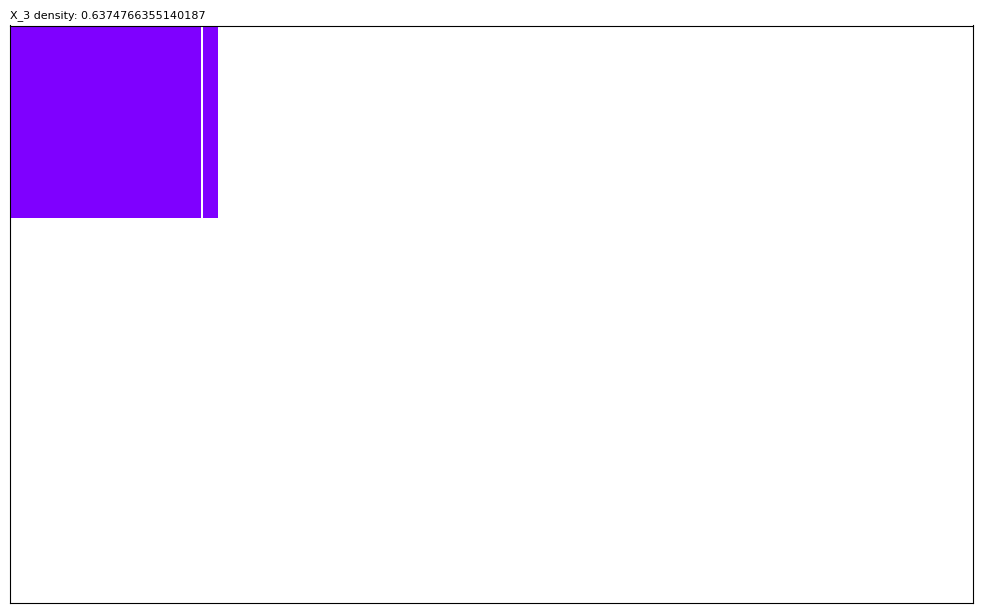

<Figure size 640x480 with 0 Axes>

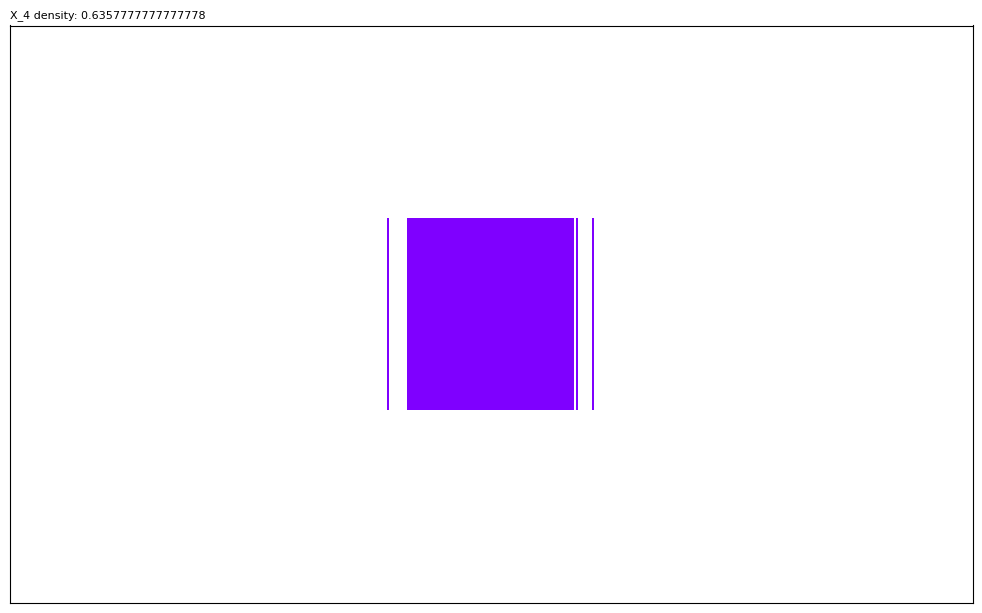

<Figure size 640x480 with 0 Axes>

In [16]:
# check pattern density

from utils import binarize, matmul, show_matrix, to_sparse, multiply

U = binarize(model_bmfts_1.U, model_bmfts_1.u)
V = binarize(model_bmfts_1.V, model_bmfts_1.v)

U, V = to_sparse(U), to_sparse(V)

X = matmul(U, V.T, sparse=True, boolean=True)
density = multiply(X, X_train).sum() / X.sum()
show_matrix([(X, [0, 0], f"X density: {density}")])

for i in range(k):
    X = matmul(U[:, i], V[:, i].T, sparse=True, boolean=True)
    density = multiply(X, X_train).sum() / X.sum()
    show_matrix([(X, [0, 0], f"X_{i} density: {density}")])

# 2.1 Init U, V randomly

If `BinaryMFPenalty` is initialized with `init_method` == `normal` or `uniform`, then `reg` and `reg_growth` should not be set too large. It's hard to tweak comparing to `NMFSklearn` init.

[I] k            : 5
[I] U            : None
[I] V            : None
[I] W            : full
[I] reg          : 1
[I] beta_loss    : frobenius
[I] solver       : mu
[I] reg_growth   : 1.1
[I] max_reg      : 10000000000.0
[I] tol          : 0.01
[I] min_diff     : 0.0
[I] max_iter     : 100
[I] init_method  : normal
[I] seed         : 2024
[I] verbose      : False
[I] display      : False
[I] task         : reconstruction
[I] display      : True
[I] U, V existed. Skipping initialization.
[I] Normalized U: [0.0008838916076722335, 0.8469211700512891] -> [0.0012578774371456367, 1.0], V: [0.00010647605073931424, 1.0574794948005815] -> [0.00012067988668126909, 1.0]
(500, 5) 1.0 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
(500, 5) 1.1 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
(500, 5) 1.2100000000000002 <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
(500, 5) 1.3310000000000004 <class 'numpy.float64'> <class 'nu

\
                                                                        
                  time iter         error     rec_error           reg   
0    17/06/24 01:53:10    0  17662.997951  17606.069209      1.000000   
1    17/06/24 01:53:10    1  17661.538891  17606.069209      1.000000   
2    17/06/24 01:53:10    2  15344.067649  15282.356335      1.100000   
3    17/06/24 01:53:10    3  15195.848030  15127.767698      1.210000   
4    17/06/24 01:53:10    4  15040.057843  14965.797577      1.331000   
5    17/06/24 01:53:10    5  14762.111631  14682.254039      1.464100   
6    17/06/24 01:53:10    6  14293.641263  14208.677777      1.610510   
7    17/06/24 01:53:11    7  13722.035198  13631.824137      1.771561   
8    17/06/24 01:53:11    8  13240.671342  13144.605785      1.948717   
9    17/06/24 01:53:11    9  12905.967748  12803.580059      2.143589   
10   17/06/24 01:53:11   10  12623.436865  12514.670314      2.357948   
11   17/06/24 01:53:11   11  12315.461420  12200.306005      2.593742   
12   17/06/24 01:53:11   12  12006.863366  11884.634162      2.853117   
13   17/06/24 01:53:11   13  11764.127738  11633.458960      3.138428   
14   17/06/24 01:53:12   14  11605.953200  11465.364222      3.452271   
15   17/06/24 01:53:12   15  11506.967000  11355.157439      3.797498   
16   17/06/24 01:53:12   16  11438.876781  11274.708687      4.177248   
17   17/06/24 01:53:12   17  11384.485728  11206.868576      4.594973   
18   17/06/24 01:53:12   18  11335.514236  11143.293440      5.054470   
19   17/06/24 01:53:12   19  11289.066374  11080.953448      5.559917   
20   17/06/24 01:53:12   20  11245.305742  11019.868044      6.115909   
21   17/06/24 01:53:13   21  11205.833614  10961.518514      6.727500   
22   17/06/24 01:53:13   22  11172.504971  10907.654501      7.400250   
23   17/06/24 01:53:13   23  11146.750292  10859.598075      8.140275   
24   17/06/24 01:53:13   24  11129.388053  10818.057023      8.954302   
25   17/06/24 01:53:13   25  11120.679990  10783.173578      9.849733   
26   17/06/24 01:53:13   26  11120.362944  10754.537674     10.834706   
27   17/06/24 01:53:13   27  11127.765736  10731.307654     11.918177   
28   17/06/24 01:53:14   28  11142.089594  10712.508686     13.109994   
29   17/06/24 01:53:14   29  11162.631074  10697.267256     14.420994   
30   17/06/24 01:53:14   30  11188.861007  10684.895572     15.863093   
31   17/06/24 01:53:14   31  11220.423810  10674.895533     17.449402   
32   17/06/24 01:53:14   32  11257.110185  10666.936620     19.194342   
33   17/06/24 01:53:14   33  11298.821015  10660.824339     21.113777   
34   17/06/24 01:53:14   34  11345.530253  10656.466015     23.225154   
35   17/06/24 01:53:14   35  11397.254867  10653.842534     25.547670   
36   17/06/24 01:53:15   36  11454.035270  10652.991419     28.102437   
37   17/06/24 01:53:15   37  11515.921303  10653.999016     30.912681   
38   17/06/24 01:53:15   38  11582.953412  10656.991036     34.003949   
39   17/06/24 01:53:15   39  11655.136225  10662.112443     37.404343   
40   17/06/24 01:53:15   40  11732.420389  10669.510663     41.144778   
41   17/06/24 01:53:15   41  11814.705841  10679.339375     45.259256   
42   17/06/24 01:53:15   42  11901.856602  10691.772745     49.785181   
43   17/06/24 01:53:16   43  11993.713141  10707.015299     54.763699   
44   17/06/24 01:53:16   44  12090.093873  10725.305543     60.240069   
45   17/06/24 01:53:16   45  12190.784296  10746.919287     66.264076   
46   17/06/24 01:53:16   46  12295.530954  10772.176215     72.890484   
47   17/06/24 01:53:16   47  12404.066090  10801.441841     80.179532   
48   17/06/24 01:53:16   48  12516.161710  10835.121705     88.197485   
49   17/06/24 01:53:16   49  12631.676062  10873.658863     97.017234   
50   17/06/24 01:53:17   50  12750.546330  10917.528340    106.718957   
51   17/06/24 01:53:17   51  12872.712101  10967.217093    117.390853   
52   17/06/24 01:53:17   52  12998.015890  11023.212095 

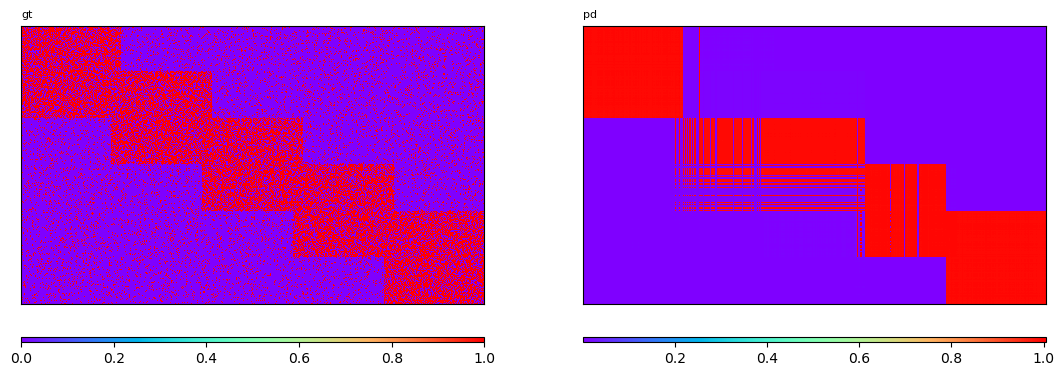

[I] model saved as: 24-06-17_13-53-24_BinaryMFPenalty.pickle


<Figure size 640x480 with 0 Axes>

In [17]:
init_method = 'normal'
# init_method = 'uniform'

reg = 1
reg_growth = 1.1

model = BinaryMFPenalty(k=k, U=None, V=None, reg=reg, reg_growth=reg_growth, init_method=init_method, max_iter=100, seed=2024)
model.fit(X_train=X_train, X_val=X_val, X_test=X_test, task=task, verbose=False, display=True)

# 2.2 Thresholding with `BinaryMFThresholdExSigmoid`

[I] k            : 5
[I] U            : (300, 5)
[I] V            : (500, 5)
[I] W            : full
[I] u            : 0.1
[I] v            : 0.1
[I] link_lamda   : 10
[I] lamda        : 100
[I] min_diff     : 0.001
[I] max_iter     : 30
[I] init_method  : custom
[I] seed         : 1718603604
[I] verbose      : False
[I] display      : False
[I] task         : reconstruction
[I] Normalized U: [1.7078758568407366e-45, 1.0000030070790524] -> [1.7078707211384667e-45, 1.0], V: [1.5113259123998817e-75, 0.9991676751283679] -> [1.5125848744113088e-75, 1.0]
[I] iter: 1, start: [0.100, 0.100], direction: [-0.530, -0.415]
[I] iter: 2, start: [0.013, 0.032], direction: [182.182, 800.064]
[W] Stopped in advance: Difference lower than threshold


train  \
                                                                    0   
                time iter         u         v             F    Recall   
0  17/06/24 01:53:24    0  0.100000  0.100000  16031.307731  0.621317   
1  17/06/24 01:53:25    1  0.013102  0.031866  14932.047236  0.621317   
2  17/06/24 01:53:26    2  0.013189  0.032248  14930.872985  0.621317   

                                      val                                \
                                        0                                 
  Precision  Accuracy        F1    Recall Precision  Accuracy        F1   
0  0.625465  0.783393  0.623384  0.621317  0.625465  0.783393  0.623384   
1  0.625465  0.783393  0.623384  0.621317  0.625465  0.783393  0.623384   
2  0.625465  0.783393  0.623384  0.621317  0.625465  0.783393  0.623384   

       test                                
          0                                
     Recall Precision  Accuracy        F1  
0  0.621317  0.625465  0.783393  0.623384  
1  0.621317  0.625465  0.783393  0.623384  
2  0.621317  0.625465  0.783393  0.623384

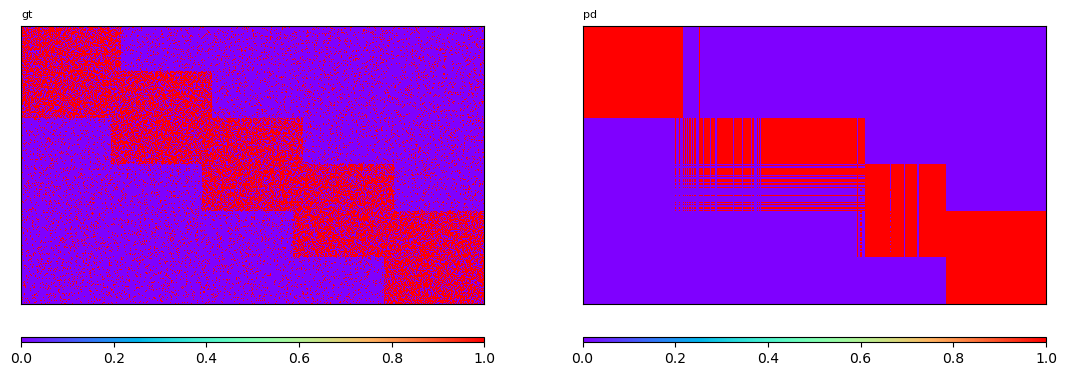

[I] model saved as: 24-06-17_13-53-28_BinaryMFThresholdExSigmoid.pickle


<Figure size 640x480 with 0 Axes>

: 

In [18]:
model_bmfts_1 = BinaryMFThresholdExSigmoid(k=k, U=model.U, V=model.V, W=W, u=u, v=v, init_method='custom')
model_bmfts_1.fit(X_train=X_train, X_val=X_val, X_test=X_test, task=task, verbose=False, display=False)